In [1]:
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import pandas as pd
import os

/Users/ender/work/PRJZ/project/Platform/AlphaGenome_tutorial/.venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.27.2 is exactly one major version older than the runtime version 6.31.1 at alphagenome/protos/dna_model.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/ender/work/PRJZ/project/Platform/AlphaGenome_tutorial/.venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.27.2 is exactly one major version older than the runtime version 6.31.1 at alphagenome/protos/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/ender/work/PRJZ/project/Platform/AlphaGenome_tutorial/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs

In [2]:
# os.environ["ALPHAGENOME_API_KEY"] = "<YOUR_API_KEY>"

## Predict Sequence

In [3]:
dna_model = dna_client.create(os.getenv("ALPHAGENOME_API_KEY"))

In [4]:
[output.name for output in dna_client.OutputType]

['ATAC',
 'CAGE',
 'DNASE',
 'RNA_SEQ',
 'CHIP_HISTONE',
 'CHIP_TF',
 'SPLICE_SITES',
 'SPLICE_SITE_USAGE',
 'SPLICE_JUNCTIONS',
 'CONTACT_MAPS',
 'PROCAP']

In [5]:
output = dna_model.predict_sequence(
    sequence='GATTACA'.center(2048, 'N'),  # Pad to valid sequence length.
    requested_outputs=[dna_client.OutputType.DNASE],
    ontology_terms=['UBERON:0002048'],  # Lung.
)

In [6]:
output.dnase.metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified
0,UBERON:0002048 DNase-seq,.,DNase-seq,UBERON:0002048,lung,tissue,embryonic,encode,paired,False


In [7]:
output = dna_model.predict_sequence(
    sequence='GATTACA'.center(2048, 'N'),  # Pad to valid sequence length.
    requested_outputs=[
        dna_client.OutputType.CAGE,
        dna_client.OutputType.DNASE,
    ],
    ontology_terms=[
        'UBERON:0002048',  # Lung.
        'UBERON:0000955',  # Brain.
    ],
)

print(f'DNASE predictions shape: {output.dnase.values.shape}')
print(f'CAGE predictions shape: {output.cage.values.shape}')

DNASE predictions shape: (2048, 2)
CAGE predictions shape: (2048, 4)


In [8]:
output.cage.metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,data_source
0,hCAGE UBERON:0000955,+,hCAGE,UBERON:0000955,brain,tissue,fantom
1,hCAGE UBERON:0002048,+,hCAGE,UBERON:0002048,lung,tissue,fantom
2,hCAGE UBERON:0000955,-,hCAGE,UBERON:0000955,brain,tissue,fantom
3,hCAGE UBERON:0002048,-,hCAGE,UBERON:0002048,lung,tissue,fantom


In [9]:
# The GTF file contains information on the location of all trancripts.
# Note that we use genome assembly hg38 for human.
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_longest_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)

In [10]:
interval = gene_annotation.get_gene_interval(gtf, gene_symbol='CYP2B6')
interval

Interval(chromosome='chr19', start=40991281, end=41018398, strand='+', name='CYP2B6')

In [11]:
interval = interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

In [12]:
interval.width

1048576

In [14]:
dna_client.SUPPORTED_SEQUENCE_LENGTHS.keys()

dict_keys(['SEQUENCE_LENGTH_2KB', 'SEQUENCE_LENGTH_16KB', 'SEQUENCE_LENGTH_100KB', 'SEQUENCE_LENGTH_500KB', 'SEQUENCE_LENGTH_1MB'])

In [15]:
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0001114'],
)  # Right liver lobe.

output.rna_seq.values.shape

(1048576, 3)

In [16]:
longest_transcripts = transcript_extractor.extract(interval)
print(f'Extracted {len(longest_transcripts)} transcripts in this interval.')

Extracted 29 transcripts in this interval.


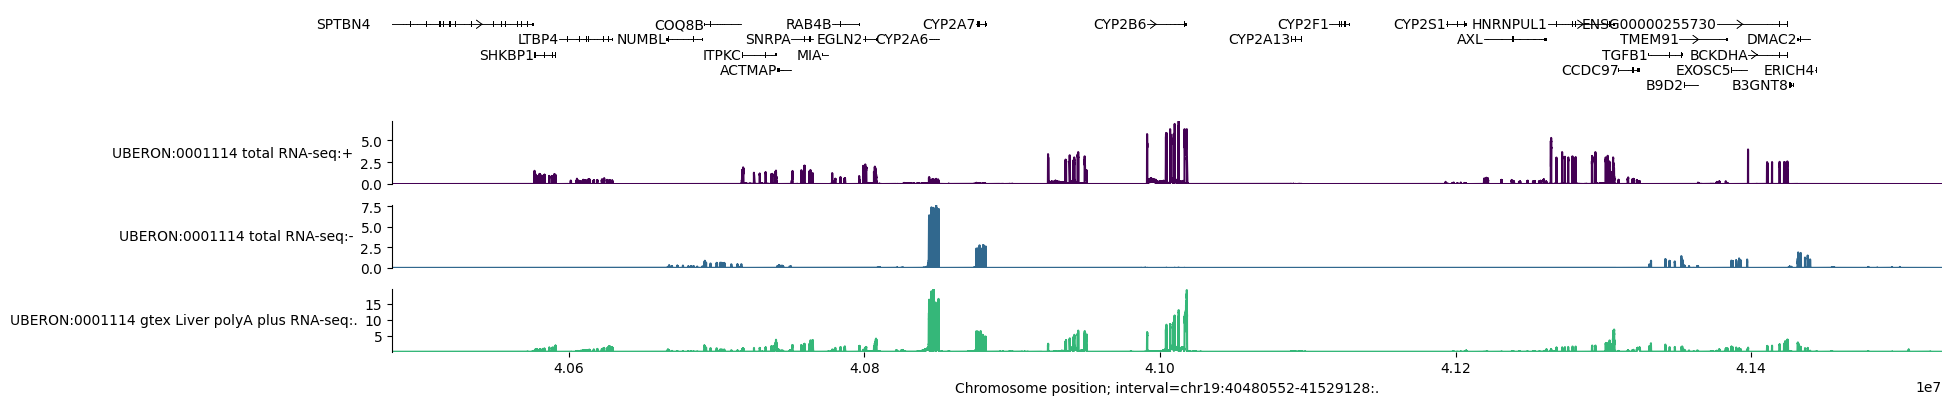

In [17]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=output.rna_seq.interval,
)

plt.show()

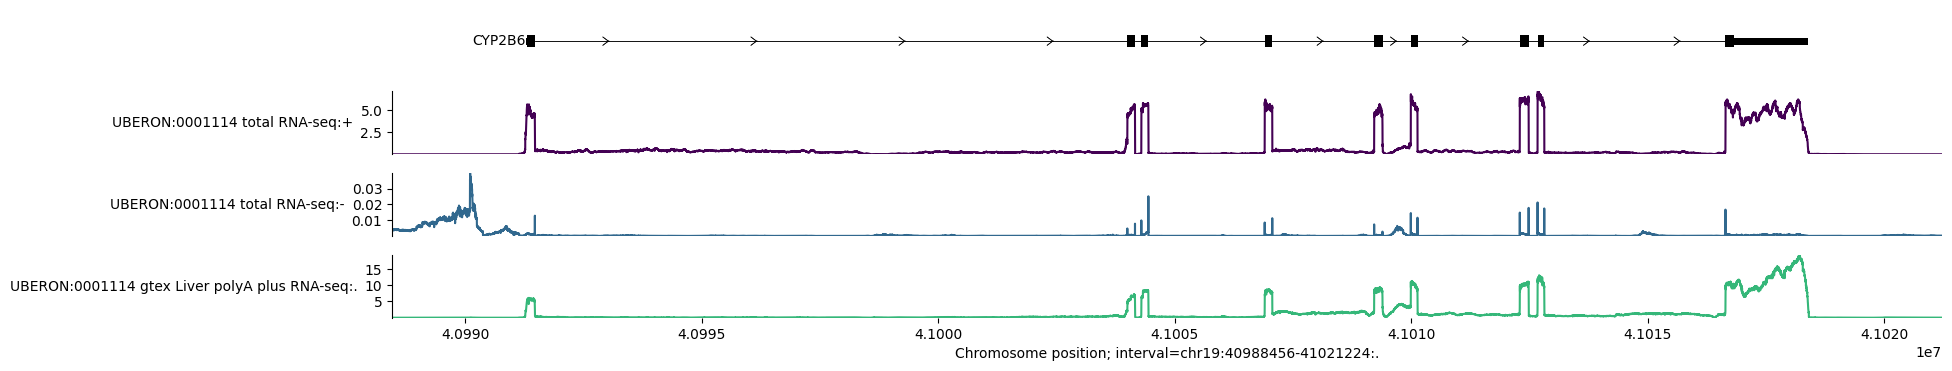

In [18]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(
            longest_transcripts, fig_height=0.1
        ),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=output.rna_seq.interval.resize(2**15),
)

plt.show()

# Predict Variants effects

In [37]:
variant = genome.Variant(
    chromosome='chr22',
    position=36201698,
    reference_bases='A',  # Can differ from the true reference genome base.
    alternate_bases='C',
)

In [38]:
interval = variant.reference_interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

In [39]:
variant_output = dna_model.predict_variant(
    interval=interval,
    variant=variant,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0001157'],
)  # Colon - Transverse.

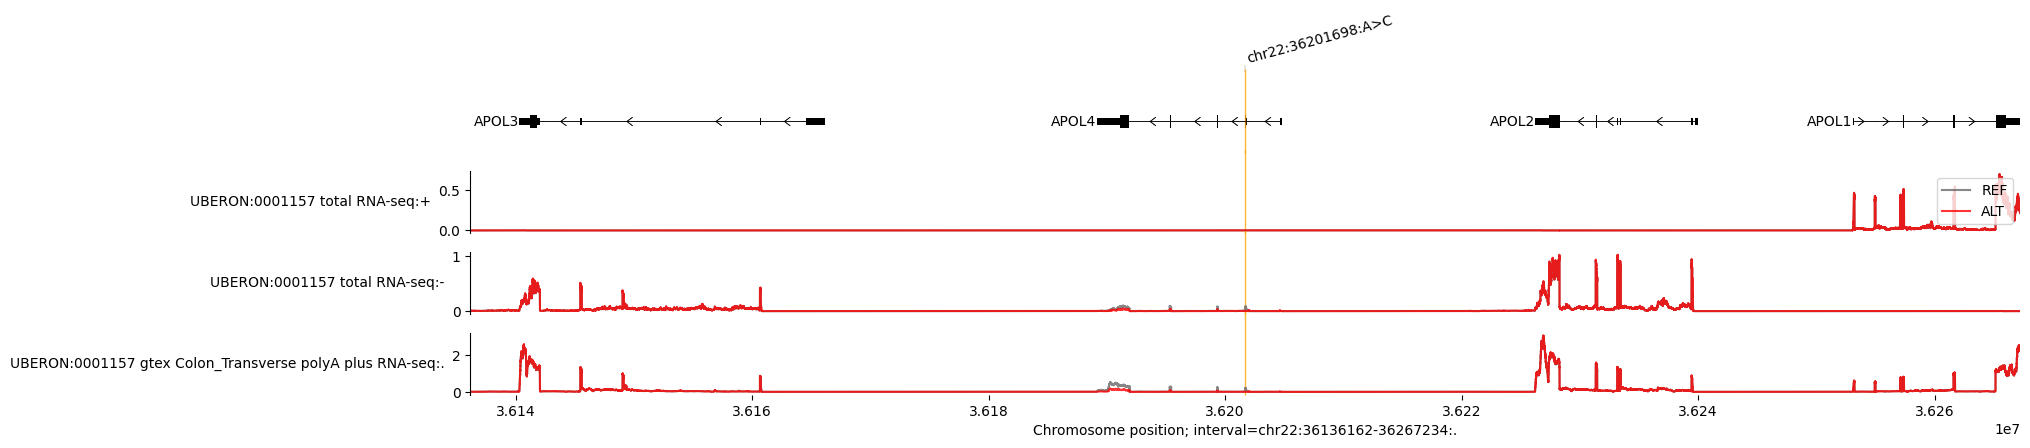

In [40]:
longest_transcripts = transcript_extractor.extract(interval)

plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.OverlaidTracks(
            tdata={
                'REF': variant_output.reference.rna_seq,
                'ALT': variant_output.alternate.rna_seq,
            },
            colors={'REF': 'dimgrey', 'ALT': 'red'},
        ),
    ],
    interval=variant_output.reference.rna_seq.interval.resize(2**17),
    # Annotate the location of the variant as a vertical line.
    annotations=[plot_components.VariantAnnotation([variant], alpha=0.8)],
)
plt.show()

# Scoring the effect of a genetic variant

In [41]:
variant_scorer = variant_scorers.RECOMMENDED_VARIANT_SCORERS['RNA_SEQ']

variant_scores = dna_model.score_variant(
    interval=interval, variant=variant, variant_scorers=[variant_scorer]
)

In [42]:
len(variant_scores)

1

In [43]:
variant_scores = variant_scores[0]
variant_scores

AnnData object with n_obs × n_vars = 37 × 667
    obs: 'gene_id', 'strand', 'gene_name', 'gene_type'
    var: 'name', 'strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'biosample_life_stage', 'gtex_tissue', 'data_source', 'endedness', 'genetically_modified'
    uns: 'interval', 'variant', 'variant_scorer'
    layers: 'quantiles'

In [44]:
print(f'Interval: {variant_scores.uns["interval"]}')
print(f'Variant: {variant_scores.uns["variant"]}')
print(f'Variant scorer: {variant_scores.uns["variant_scorer"]}')

Interval: chr22:35677410-36725986:.
Variant: chr22:36201698:A>C
Variant scorer: GeneMaskLFCScorer(requested_output=RNA_SEQ)


In [45]:
variant_scorers.tidy_scores([variant_scores], match_gene_strand=True)

,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,track_name,track_strand,Assay title,ontology_curie,biosample_name,biosample_type,gtex_tissue,raw_score,quantile_score
0,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000047 polyA plus RNA-seq,-,polyA plus RNA-seq,CL:0000047,neuronal stem cell,in_vitro_differentiated_cells,,0.000903,0.606708
1,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000062 total RNA-seq,-,total RNA-seq,CL:0000062,osteoblast,primary_cell,,-0.000363,-0.477020
2,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000084 polyA plus RNA-seq,-,polyA plus RNA-seq,CL:0000084,T-cell,primary_cell,,-0.007063,-0.989667
3,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000084 total RNA-seq,-,total RNA-seq,CL:0000084,T-cell,primary_cell,,-0.007229,-0.990997
4,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000115 total RNA-seq,-,total RNA-seq,CL:0000115,endothelial cell,in_vitro_differentiated_cells,,0.000461,0.449849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14647,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0018115 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018115,left renal pelvis,tissue,,0.006467,0.989427
14648,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0018116 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018116,right renal pelvis,tissue,,0.007303,0.992679
14649,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0018117 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018117,left renal cortex interstitium,tissue,,0.004375,0.964537
14650,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0018118 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018118,right renal cortex interstitium,tissue,,0.003006,0.905090


# Highlighting important regions with in silico mutagenesis

In [46]:
# 2KB DNA sequence to use as context when making predictions.
sequence_interval = genome.Interval('chr20', 3_753_000, 3_753_400)
sequence_interval = sequence_interval.resize(dna_client.SEQUENCE_LENGTH_2KB)

# Mutate all bases in the central 256-base region of the sequence_interval.
ism_interval = sequence_interval.resize(256)

In [47]:
dnase_variant_scorer = variant_scorers.CenterMaskScorer(
    requested_output=dna_client.OutputType.DNASE,
    width=501,
    aggregation_type=variant_scorers.AggregationType.DIFF_MEAN,
)

In [49]:
# variant_scores = dna_model.score_ism_variants(
#     interval=sequence_interval,
#     ism_interval=ism_interval,
#     variant_scorers=[dnase_variant_scorer],
# )